<a href="https://colab.research.google.com/github/s1c5000/tensorflow2.0/blob/main/%EC%82%AC%EC%A0%84%ED%9B%88%EB%A0%A8%EB%90%9C%EB%AA%A8%EB%8D%B8%EB%8B%A4%EB%A3%A8%EA%B8%B0_08_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 8.2.2 특징 추출기

미리훈련된 모델에서 데이터의 특징만 추출하고, 그 특징을 작은 네트워크에 통과시켜 정답을 예측하는 방법도있다. 미리추출한 특징은 파일로 저장했다 필요할 때 분러서 사용. 학습할때마다 전체 네트워크의 계산을 반복할 필요가 없기 때문에 계산 시간은 줄어든다. 다만 미리 훈련된 모델에서는 사용하기 어렵다는 단점있다.

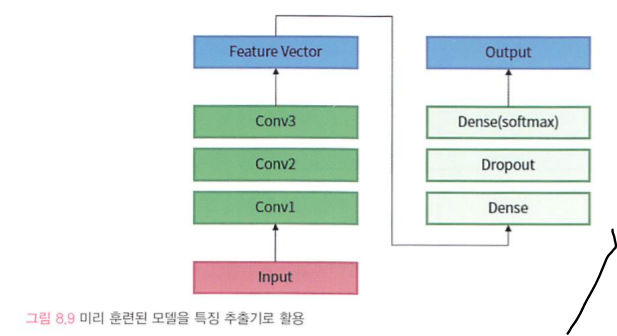

텐서플로 허브에서 Inception V3을 불러오겠다. inception은 2014년 구글이 imagenet대회를 위해 GoogleNet이라는 이름으로 발표한 컨볼루션 신경먕이다.     
텐서플로 허브에는 소프트맥스 Dense 레이어를 포함한 전체 네트워크와, 소프트맥스 Dense레이어가 없는 특징 추출기 네트워크가 있는데 여기서는 특징 추출기 네트워크를 kerasLayer로 불러오겠다.

In [ ]:

# 8.23 텐서플로우 허브에서 사전 훈련된 Inception V3의 특징 추출기 불러오기
import tensorflow_hub as hub
import tensorflow as tf

inception_url = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_model = tf.keras.Sequential([
    hub.KerasLayer(inception_url, output_shape=(2048,), trainable=False)
])
feature_model.build([None, 299, 299, 3])
feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


kerasLayer형식으로 모델 안에 들어가는 하나의 레이어로 전체 네트워크를 불러올 수 있다. inception V3에서 마지막 Dense 레이어에 넘겨주는 출력의 크기는 2048이고 특징추출기는 마지막 Dnese레이어를 포함하지 않기 때문에 output_shape=(2048)로 출력 크기를 지정한다.(뒤의 Dense레이어는 가져오지 않아서 그렇다)     
summary() 를 보기 전 보통 compile()함수를 먼저 실행해야 하지만 build()함수를 사용할 수도 있다. 네트워크의 input_shape가 정해지지 않았기 때문에 인수로[None, 299, 299, 3]이라는 입력데이터의 차원을 정의해서넣는다    
첫번째 차원은 배치 차원이기 대문에 입력이 몇개가 들어와도 상관없도록 제한을 두지 않는 것 이다.          

inception v3는 299크기의 이미지를 받는다 훈련데이터 전체를 299로 조정해서 메모리에 올리면 메모리 부족으로 코랩이 다운된다. 해서 ImagedataGenerator를 사용해 이미지를 필요할때마다 디스크에서 배치크기만큼 읽어 들이는 방법을 사용할 수 있다.      
그런데 ImageDataGeneratior는 라벨이 있는 데이터르 처리할 때 각 라벨의 이름을 하위 디렉터리로 가지고 있는 디렉터리를 받아서 그 데이터를 처리한다. 반면 캐글에서 받은 데이터들은 하위 디렉터리의 구분없이 train폴더에 모든 이미지가 저장되어있다. 따라서 ImageDataGenerater가 처리할 수 있는 방식으로 데이터를 복사하는 작업을 해야한다

In [ ]:
# kaggle API를 설치합니다.
!pip install kaggle

In [ ]:
# 8.8 Stanford Dog Dataset을 Kaggle에서 불러오기
import tensorflow as tf
# 2020.02.01 현재 kaggle의 Stanford Dog Dataset 파일 구조가 변경되었습니다. 
# kaggle API를 사용하는 대신에 아래 링크에서 파일을 직접 받아오도록 수정되었습니다.
tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

import os
os.environ['KAGGLE_USERNAME'] = 'leemj5000' # 독자의 캐글 ID
os.environ['KAGGLE_KEY'] = '9761000ca5f89a908cb4e6462dad9e0b' # 독자의 캐글 API Token
# !kaggle competitions download -c dog-breed-identification

362848256/362841195 [==============================] - 23s 0us/step


In [ ]:
# 8.9 파일의 압축 풀기
!unzip train.zip
!unzip labels.csv.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/841463629c4833816e216cbb041c2778.jpg  
  inflating: train/8429dcca4ae91c4e0345e4ba48b0d69f.jpg  
  inflating: train/842e3c6e44fda4102

In [ ]:
import pandas as pd
label_text = pd.read_csv('labels.csv')
print(label_text.head())

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
# 8.24 ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

os.mkdir('/content/train_sub')

for i in range(len(label_text)):
    if os.path.exists('/content/train_sub/' + label_text.loc[i]['breed']) == False:
        os.mkdir('/content/train_sub/' + label_text.loc[i]['breed'])
    shutil.copy('/content/train/' + label_text.loc[i]['id'] + '.jpg', '/content/train_sub/' + label_text.loc[i]['breed'])

shutil.copy(src, dst, *, follow_symlinks=True)     
파일 src를 파일이나 디렉터리 dst에 복사한다. src와 dst는 문자열이여야한다.
fllow_symlinks가 False고 src가 심볼릭링크(원본파일의 이름을 가리키는 링크)이면 dst는 심볼릭 링크로 만들어진다. follow_symlinks가 True고 src가 심볼릭 링크이면 dst는 src가 참조하는 사본이 된다.

imageDataGenerator가 처리할 수 있도록 디렉터리를 저장하였다.       
훈련데이터와 검증데이터를 분리하고 훈련데이터엔 이미지보강(image Augmentation)을 적용하겠다.

In [ ]:
# 8.25 ImageDataGenerator를 이용한 train/validation 데이터 분리, Image Augmentation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True,
    shear_range=0.2, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, validation_split=0.25)
valid_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25)

train_generator = train_datagen.flow_from_directory(directory="/content/train_sub/",
    subset="training", batch_size=batch_size, seed=42, shuffle=True, class_mode="categorical",
     target_size=(image_size, image_size))
valid_generator = valid_datagen.flow_from_directory(directory="/content/train_sub/", 
    subset="validation", batch_size=1, seed=42, shuffle=True, class_mode="categorical",
     target_size=(image_size, image_size))

Found 7718 images belonging to 120 classes.
Found 2504 images belonging to 120 classes.


ImageDataGenerator를 만들고 train_datagen, 과 valid_datagen을 만든다.      
train_datagen은 픽셀정규화(rescale=1.255), 좌우반전, 기울이기, 줌, 좌우/상하 평행이동을 수행하고,      
vliad_datagen은 픽셀 정규화만 실행한다.     
생성할 이미지는 batch_size로 설정한다.      
양쪽 모두 validation_split을 0.25로 지정해서 25%를 검증데이터로 뺀다.      
flow_from_directory는 이미지를 불러올 때 폴더명에 맞춰 자동으로 labelling을 해준다      
그 후 양쪽의 ImageDataGenerator를 각각 사용하는 train_generator, valid_generator를 flow_from_directory()함수로 만든다.     
ImageDataGenerator는 라벨을 인덱스로 저장할때 알파벳 순으로 정렬한뒤 저장한다.     
7718+2504 = 10222(전체이미지개수)

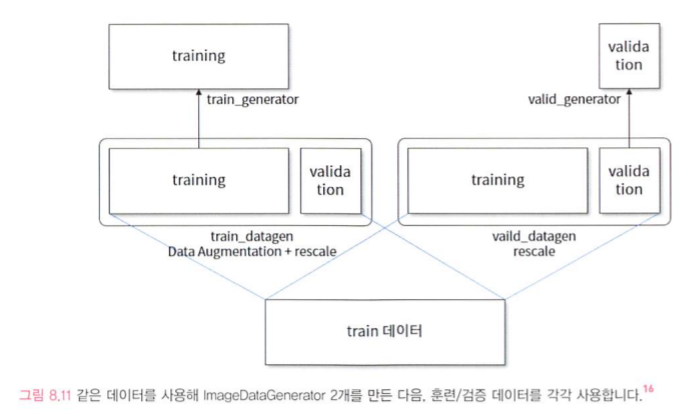

ImageDataGenerator를 2개 사용하는 이유는 네트워크를 학습시킬 훈련 데이터에는 이미지 보강을 위한 ImageDataGenerator를 사용하고, 검증 데이터에는 별도의 이미지 보강없이 원본 데이터를 사용하기 위해서이다. 양쪽 train_generator와 valid_generator의 seed값을 같은 것으로 밪춰주기 때문에 ImageDataGenerator에는 동일한 training, validation 부분 집합이 생긴다.     
train_generator는 training부분집합을 사용하고  valid_generator는 validation부분집합을 사용한다.

Inception V3특징 추출기를 이용해 훈련 데이터와 검증데이터를 특징 벡터로 변환하는 작업이 필요하다.     
이렇게 변환한 특징 벡터를 작은 시퀀셜모델에 넣어서 라벨을 예측할 것이다

In [ ]:
# 8.26 train 데이터를 특징 벡터로 변환
batch_step = (7718 * 3) // batch_size
train_features = []
train_Y = []
for idx in range(batch_step):
    if idx % 100 == 0:
        print(idx)
    x, y = train_generator.next()
    train_Y.extend(y)
    
    feature = feature_model.predict(x)
    train_features.extend(feature)


0
100
200
300
400
500
600
700


In [ ]:
import numpy as np
train_features = np.array(train_features)
train_Y = np.array(train_Y)
# (7718 * 3) // batch_size = 723
# 723(step) * 32(이미지당 보강 수) = 23,136  약23084
print(train_features.shape)
print(train_Y.shape)

(23084, 2048)
(23084, 120)


첫 줄에는 batch_size를 지정한다. training 부분집합의 크기인 7718에 3을 곱해서 충분한 이미지 보강이 되게하고, batch_size(32)로 나눠서 training부분집합을 3번정도 반복해서 특징 벡터를 뽑는다.        
ImageDataGenerator에 next()함수를 사용하면 다음에 올 값을 반환받을 수 있다. 훈련데이터에는 이미지의 분류에 해당하는 y 값이 있기 때문에 y값도 받아서 train_Y에 저장해둔다.     
x 값은 이미지 데이터에 해당하는 부분이다. 특징추출기를 통과하면 특징 벡터가 된다. 이미 학습이 완료된 특징 추출기를사용하기 때문에 predict()로 특징 벡터를 추출한다. 그 후 train_features에 저장한다

최종 출력의 shape는 train_features가( 23084,2048이고 ) train_Y가 (23084, 120)이다.       
특징벡터는 2048차원의 벡터이다. 가로,세로 299 *3(채널)의 이미지가 2048개의 실수로 변환됐으니 데이터의 크기는 원본에 비해 2048/(299 * 299 * 3)*100=0.76%로 크게 줄어들었다.

In [ ]:
# 8.27 validation 데이터를 특징 벡터로 변환
valid_features = []
valid_Y = []

for idx in range(valid_generator.n):
    if idx % 100 == 0:
        print(idx)
    x, y = valid_generator.next()
    valid_Y.extend(y)
    
    feature = feature_model.predict(x)
    valid_features.extend(feature)

valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)
print(valid_features.shape)
print(valid_Y.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
(2504, 2048)
(2504, 120)


valid_generator의 값을 특징벡터로 전환하였다.      
valid_generator.n은 데이터의 크기를 나타낸다.     
이제 특징 벡터가 준비됐으니 분류를위한 네트워크를 만들어보겠다. 작은 시퀸셜모델이면 충분하다

In [ ]:
# 8.28 분류를 위한 작은 Sequential 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(2048,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

model.compile(tf.optimizers.RMSprop(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 555,384
Trainable params: 555,384
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
722/722 [==============================] - 3s 5ms/step - loss: 2.9028 - accuracy: 0.4410 - val_loss: 0.9647 - val_accuracy: 0.8614
Epoch 2/10
722/722 [==============================] - 3s 4ms/step - loss: 0.9631 - accuracy: 0.7760 - val_loss: 0.4288 - val_accuracy: 0.8898
Epoch 3/10
722/722 [==============================] - 3s 4ms/step - loss: 0.6371 - accuracy: 0.8248 - val_loss: 0.3505 - val_accuracy: 0.8998
Epoch 4/10
722/722 [==============================] - 3s 4ms/step - loss: 0.5181 - accuracy: 0.8450 - val_loss: 0.3242 - val_accuracy: 0.8970
Epoch 5/10
722/722 [==============================] - 3s 4ms/step - loss: 0.4448 - accuracy: 0.8649 - val_loss: 0.3038 - val_accuracy: 0.9058
Epoch 6/10
722/722 [==============================] - 3s 4ms/step - loss: 0.4074 - accuracy: 0.8749 - val_loss: 0.3000 - val_accuracy: 0.9022
Epoch 7/10
722/722 [==============================] - 3s 4ms/step - loss: 0.3724 - accuracy: 0.8835 - val_loss: 0.2996 - val_accuracy: 0.9058
Epoch 

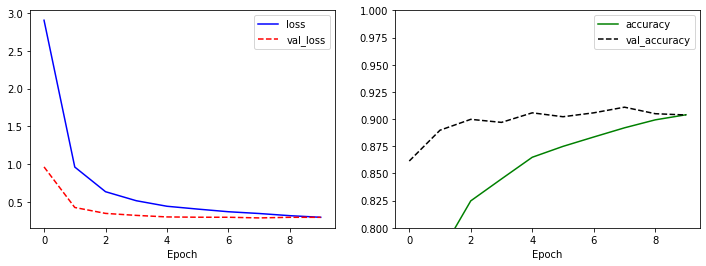

In [ ]:

# 8.29 분류를 위한 작은 Sequential 모델 학습
history = model.fit(train_features, train_Y, validation_data=(valid_features, valid_Y), epochs=10, batch_size=32)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.8, 1)
plt.legend()

plt.show()

fit()의 인수로 train_features를 넣었고 검증을 위한 validation_data를 지정하고 여기도 valid_features를 넣어서 특징 추출기의 출력을 사용하고있다. 이미지 보강과 크기가 커진 이미지 데이터를 사용해서 학습은 전반적으로 잘 되는 모습이다. val_accuracy는 90%를 넘겼다.     
학습속도도 매우 빨라졌다. 특징 추출기를 사용하면 더 많은 파라미터와 큰 이미지를 사용하면서도 학습 속도를 획기적으로 줄일 수 있다.      
[특징추출기]
미리 훈견된 모델에서 데이터의 특징만 추출하고 그 특징을 작은 네트워크에 통과시켜 정답을 예측하는 방법

In [ ]:
# 8.30 라벨 텍스트를 알파벳 순으로 정렬
unique_Y = label_text['breed'].unique().tolist()
unique_sorted_Y = sorted(unique_Y)
print(unique_sorted_Y)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

검증데이터의 이미지에 대한 분류를 시각화해보겠다.   
그 전에 먼저 라벨의 이름을 정해야하는데 ImageDataGenerator에서는 라벨을 인덱스로 저장할때 알파벳 순서로 저장하기때문에 여기서도 그에 맞게 unique_Y를 정렬하겠다.

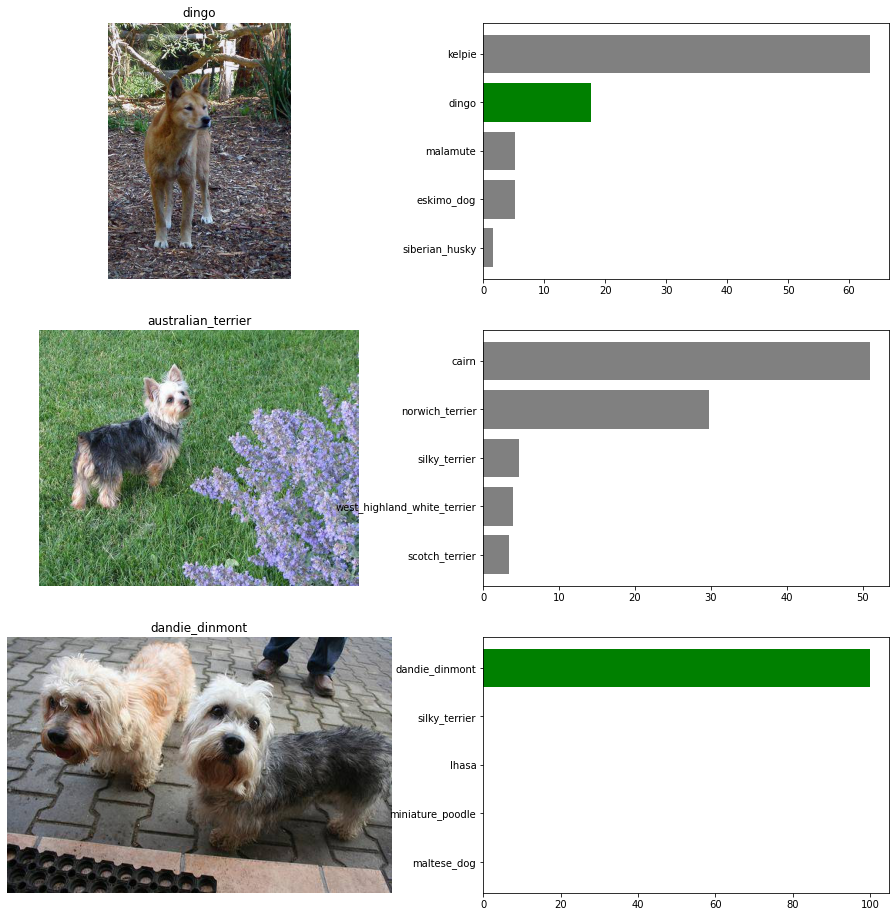

In [ ]:
# 8.31 Inception V3 특징 추출기-Sequential 모델의 분류 라벨 확인
import random
import cv2
plt.figure(figsize=(16,16))
  
for c in range(3):
    image_path = random.choice(valid_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    idx = unique_sorted_Y.index(real_y)
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # Sequential 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    if idx in top_5_predict:
        color[top_5_predict.tolist().index(idx)] = 'green'
    color = color[::-1]
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

이제 모델을 계산한 결과를 실제로 캐글 competition에 올려 지금까지 한번도 본적 없는 테스트 데이터에 대한 예측 성적이 어떻게 나오는지 알아보겠다. 캐글은 테스트 데이터에 대한 정답이 주어지지 않기 때문에 모델의 성능을 최종적으로 평가하기 위해서는 캐글에 모델의 계산 결과를 csv파일로 올렸을때 나오는 점수로 판단해야한다.      

캐글을 임포트할때 받았던 파일을 압축해제한다

In [ ]:
# 8.32 test 데이터의 압축 풀기
!unzip test.zip
!unzip sample_submission.csv.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/82e5e34cc18b267ef7057cc92de8b44b.jpg  
  inflating: test/82e64f28df4fff22beb11e9a1e413212.jpg  
  inflating: test/82ec6bdf968a14923340179515ce5546.jpg  
  inflating: test/82ee3ee4dc01b33203a049c6c3338034.jpg  
  inflating: test/82f07a63a1f03ff9d8e0f4a8458caa93.jpg  
  inflating: test/82f5fb0bdaff30a4a3374e2d9915856c.jpg  
  inflating: test/82fbff1bd375474e3d4ec5cbfde3f9f0.jpg  
  inflating: test/8301c772feb7f4068473f0157ae58f9b.jpg  
  inflating: test/8307be57a9d76c1584e16801a39cb1dc.jpg  
  inflating: test/831a38bd2cfa0a093967d5b6c1ac09dc.jpg  
  inflating: test/831ef824af939f9754e3593638933b64.jpg  
  inflating: test/8322f53b29325419ef3bcf7cf10d7172.jpg  
  inflating: test/83233e2774e116ef34a04c53dd00a282.jpg  
  inflating: test/832cae23410e741ecd2014b3818ed7c4.jpg  
  inflating: test/833f90a3652b06607b55bd25c8d97457.jpg  
  inflating: test/8341f50a86c819b3cb8828740a97e7ef.jpg  
  inflating: test/834bb31410410852082813d2e07c3290.j

먼저 submission.csv 파일의 내용을 확인해보겠다


In [ ]:
# 8.33 submission.csv 파일 내용 확인
import pandas as pd
submission = pd.read_csv('sample_submission.csv')
print(submission.head())
print()
print(submission.info())

                                 id  ...  yorkshire_terrier
0  000621fb3cbb32d8935728e48679680e  ...           0.008333
1  00102ee9d8eb90812350685311fe5890  ...           0.008333
2  0012a730dfa437f5f3613fb75efcd4ce  ...           0.008333
3  001510bc8570bbeee98c8d80c8a95ec1  ...           0.008333
4  001a5f3114548acdefa3d4da05474c2e  ...           0.008333

[5 rows x 121 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10357 entries, 0 to 10356
Columns: 121 entries, id to yorkshire_terrier
dtypes: float64(120), object(1)
memory usage: 9.6+ MB
None


데이터프레임의 첫 열은 labels.csv와 같은 id 이다. 나머지 열은 120개의 견종의 이름이고, 각 id에 대한 각 견종의 예측값은 랜덤한 선택을 했을때의 0.00833으로 채워져있다. 이대로 캐글에 제출하면 4.78749라는 점수를 얻는다 이 점수는 multiclass Logloss로 산정되며 낮을 수록 좋다. (1300팀중 약 1100등정도의 수준이다)

Multiclass logloss는 범주에 대한 크로스엔트로피이다. 모델을 컴파일 할때 loss를 categorical_crossentropy로 설정하면 fit() 함수의 출력 창에서 훈련 데이터의 multiclass logloss인 loss와 검증 데이터의 multiclass logloss인 val_loss를 확인 할수 있다.

마지막 에포크에서 loss는 0.29, val_loss는 0.30이였다. val_loss가 학습과정에서 한번도 보지못한 데이터에 대한 multiclass logloss이기때문에 테스트 데이터에 대한 multiclass logloss도 이와 비슷한 값이 나올 것이다.      
테스트 데이터도 훈련 데이터와 마찬가지로 299크기의 데이터를 사용할 것이기 때문에 imageDataGenerator를 사용하겠다. 역시 ImageDataGenerator가 flow_from_directory()함수로 이미지르 읽어 들이기 위해선는 하위 디렉터리가 필요하다. 현제 테스트 데이터는 각 사진이 어떤 범주에 속하는지 알 수 없기 때문에 unknown이라는 디렉터리를 하나 만들고 모든 데이터를 이곳에 복사하겠다.

In [ ]:
# 8.34 ImageDataGenerator가 처리할 수 있는 하위 디렉토리 구조로 데이터 복사
import os
import shutil

os.mkdir('/content/test_sub/')
os.mkdir('/content/test_sub/unknown/')

for i in range(len(submission)):
    shutil.copy('/content/test/' + submission.loc[i]['id'] + '.jpg', '/content/test_sub/unknown/')

In [ ]:
# 8.35 ImageDataGenerator를 이용한 test 데이터 불러오기
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(directory="/content/test_sub/",batch_size=1,seed=42,shuffle=False,target_size=(299, 299))

Found 10357 images belonging to 1 classes.


In [ ]:
# 8.36 test 데이터를 특징 벡터로 변환
test_features = []

for idx in range(test_generator.n):
    if idx % 100 == 0:
        print(idx)
        
    x, _ = test_generator.next()
    feature = feature_model.predict(x)
    test_features.extend(feature)

test_features = np.array(test_features)
print(test_features.shape)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
(10357, 2048)


각 이미지 데이터는 2048의 길이를 가진 특징 벡터로 변환됐다. 이제 특징벡터를 학습시킨 모델에 넣어서 정답을 예측한다.

In [ ]:
# 8.37 특징 벡터로 test 데이터의 정답 예측
test_Y = model.predict(test_features, verbose=1)

324/324 [==============================] - 0s 2ms/step


verbose의 기본값이 0이기때문에 진행과정을 보려면 verbose를 1로 지정해야한다

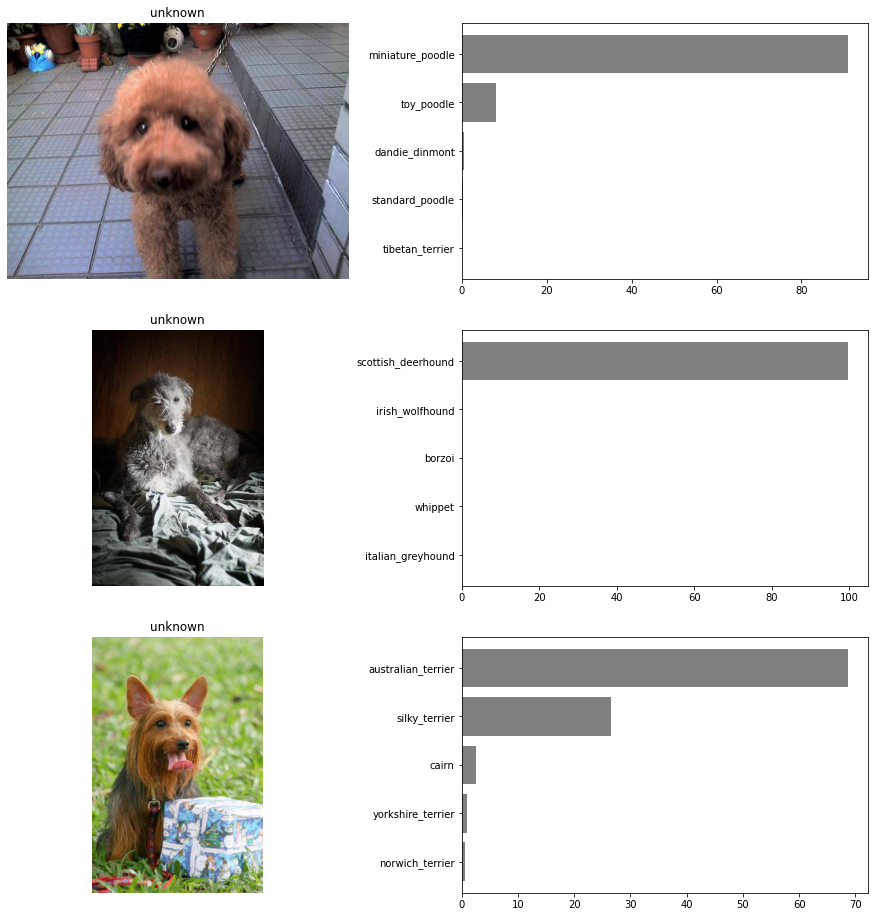

In [ ]:
# 8.38 Inception V3 특징 추출기-Sequential 모델의 test 데이터 분류 라벨 확인
import random
plt.figure(figsize=(16,16))
  
for c in range(3):
    image_path = random.choice(test_generator.filepaths)
    
    # 이미지 표시
    plt.subplot(3,2,c*2+1)
    plt.imshow(plt.imread(image_path))
    real_y = image_path.split('/')[3]
    plt.title(real_y)
    plt.axis('off')
    
    # 예측값 표시
    plt.subplot(3,2,c*2+2)
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(299, 299))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Inception V3를 이용한 특징 벡터 추출
    feature_vector = feature_model.predict(img)
    
    # Sequential 모델을 이용한 예측
    prediction = model.predict(feature_vector)[0]
    
    # 가장 높은 확률의 예측값 5개를 뽑음
    top_5_predict = prediction.argsort()[::-1][:5]
    labels = [unique_sorted_Y[index] for index in top_5_predict]
    color = ['gray'] * 5
    plt.barh(range(5), prediction[top_5_predict][::-1] * 100, color=color)
    plt.yticks(range(5), labels[::-1])

이제 실제로 캐글에 결과를 업로드하기 위해 submission이라는 이름으로 불러온 데이터프레임에 test_Y로 저장된 예측값을 넣겠다.

In [ ]:
# 8.39 submission 데이터프레임에 예측값 저장
for i in range(len(test_Y)):
    for j in range(len(test_Y[i])):
        breed_column = unique_sorted_Y[j]
        submission.loc[i, breed_column] = test_Y[i, j]

In [ ]:
# 8.40 submission 데이터 확인
print(submission.iloc[:5, :5])

                                 id  ...      airedale
0  000621fb3cbb32d8935728e48679680e  ...  1.062472e-06
1  00102ee9d8eb90812350685311fe5890  ...  1.351987e-07
2  0012a730dfa437f5f3613fb75efcd4ce  ...  1.057912e-04
3  001510bc8570bbeee98c8d80c8a95ec1  ...  3.134998e-07
4  001a5f3114548acdefa3d4da05474c2e  ...  1.227173e-06

[5 rows x 5 columns]


In [ ]:
# 8.41 submission 데이터프레임을 csv 파일로 저장
submission.to_csv('dogbreed_submission_inceptionV3_epoch10_299.csv', index=False)